In [ ]:
import sys
sys.path.add('..')
import argparse
import glob
from itertools import chain, combinations, product
import math
import os
import random
import pickle
import copy
import warnings
warnings.filterwarnings(
    "ignore",
    message = "Using padding='same'",
    category = UserWarning
)

# IMPORT STANDARD PACKAGES
import numpy as np
import pandas as pd

# IMPORT TORCH
import torch
import torch.nn as nn
from torchaudio import transforms
from torch.utils.data import DataLoader

# IMPORT SELFEEG 
import selfeeg
import selfeeg.models as zoo
import selfeeg.dataloading as dl

# IMPORT REPOSITORY FUNCTIONS
from AllFnc import split
from AllFnc.training import (
    loadEEG,
    lossBinary,
    lossMulti,
    train_model,
    get_performances,
    GetLearningRate
)
from AllFnc.utilities import (
    restricted_float,
    positive_float,
    positive_int_nozero,
    positive_int,
    str2bool
)

class BasicDataset(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [ ]:
dataPath       = '/data/delpup/datasets/eegpickle/'
pipelineToEval = 'filt'
taskToEval     = 'bci'
modelToEval    = 'resnet'
kfoldstrat     = 'nlnso'
outerFold      = 1
innerFold      = 1
downsample     = True
z_score        = True
rem_interp     = True
batchsize      = 64
overlap        = 0.0
workers        = 0
window         = 4.1
verbose        = True
lr             = 0.0
device         = torch.device('cuda:0')
seed = 83136297

if taskToEval == 'bci' and window > 4.1:
    raise ValueError(
        'bci task has trials of length 4.1 seconds. Cannot exceed this number'
    )
elif taskToEval == 'bci' and window == 4.0:
    window = 4.1

In [ ]:
if kfoldstrat in ['lnso', 'nlnso', 'nkfld']:
    Nouter = 10
    Ninner = 10
    foldToEval = outerFold*Ninner + innerFold
    subject_list = [i for i in range(1,110) if i not in [88,92,100]] 
    partition_list = split.create_nested_kfold_subject_split(subject_list, Nouter, Ninner)

In [ ]:
if dataPath[-1] != os.sep:
    dataPath += os.sep
if pipelineToEval[-1] != os.sep:
    eegpath = dataPath + pipelineToEval + os.sep
else:
    eegpath = dataPath + pipelineToEval

# Define the number of Channels to use. 
# Basically 61 due to BIDSAlign channel system alignment.
# Note that BIDSAlign DOES NOT delete any original channel by default.
if rem_interp:
    if taskToEval == 'alzheimer':
        Chan = 19
    elif taskToEval == 'parkinson':
        Chan = 32
    elif taskToEval == 'bci':
        Chan = 61
    elif taskToEval == 'sleep':
        Chan = 59
    elif taskToEval == 'psychosis':
        Chan = 56
else:
    Chan = 61

# Define the sampling rate. 125 or 250 depending on the downsampling option
# NOTE: that BCI has an original sampling rate of 160. Its downsample
#       will be handeled during the creation of the dataset and dataloader
if taskToEval == 'bci':
    freq = 160
else:
    freq = 125 if downsample else 250

# Define the number of classes to predict.
if taskToEval == 'alzheimer':
    nb_classes = 3
elif taskToEval == 'bci':
    nb_classes = 4
else:
    nb_classes = 2

# For selfEEG's models instantiation
Samples = int(freq*window)

# Set the Dataset ID for glob.glob operation in SelfEEG's GetEEGPartitionNumber().
# It is a single number for every task except for PD that merges two datasets
if taskToEval == 'alzheimer':
    datasetID = '10'
elif taskToEval.casefold() == 'sleep':
    datasetID = '20'
elif taskToEval.casefold() == 'psychosis':
    datasetID = '7'
elif taskToEval == 'bci':
    datasetID = '99'
else:
    datasetID_1 = '5' # EEG 3-Stim
    datasetID_2 = '8' # UC SD

# Set the class label in case of plot of functions
if taskToEval == 'alzheimer':
    class_labels = ['CTL', 'FTD', 'AD']
elif taskToEval == 'bci':
    class_labels = ['LeftMove', 'RightMove', 'LeftImg', 'RightImg']
elif taskToEval.casefold() == 'sleep':
    class_labels = ['Normal', 'Deprived']
elif taskToEval.casefold() == 'psychosis':
    class_labels = ['CTL', 'FEP']
else:
    class_labels = ['CTL', 'PD']

In [ ]:
loadEEG_args = {
    'return_label': False, 
    'downsample': downsample, 
    'use_only_original': rem_interp,
    'apply_zscore': z_score
}

if taskToEval.casefold() == 'parkinson':
    glob_input = [datasetID_1 + '_*.pickle', datasetID_2 + '_*.pickle' ]
else:
    glob_input = [datasetID + '_*.pickle']

# calculate dataset length with selfgeeg. Basically it automatically
# retrieves all the partitions that can be extracted from each EEG signal
EEGlen = dl.get_eeg_partition_number(
    eegpath,
    freq,
    window,
    overlap, 
    file_format = glob_input,
    load_function = loadEEG,
    optional_load_fun_args = loadEEG_args,
    includePartial = False if overlap == 0 else True,
    verbose = verbose
)

# Now we also need to load the labels
loadEEG_args['return_label'] = True

# Set functions to retrieve dataset, subject, and session from each filename.
# They will be used by GetEEGSplitTable to perform a subject based split
dataset_id_ex  = lambda x: int(x.split(os.sep)[-1].split('_')[0])
subject_id_ex  = lambda x: int(x.split(os.sep)[-1].split('_')[1]) 
session_id_ex  = lambda x: int(x.split(os.sep)[-1].split('_')[2]) 

# Set subjects to exclude.
if taskToEval == 'bci':
    exclude_id = [88,92,100]
else:
    exclude_id = None

In [ ]:
train_id   = partition_list[foldToEval][0]
val_id     = partition_list[foldToEval][1]
test_id    = partition_list[foldToEval][2]
EEGsplit= dl.get_eeg_split_table(
    partition_table      = EEGlen,
    val_data_id          = val_id,
    test_data_id         = test_id,
    exclude_data_id      = exclude_id,
    split_tolerance      = 0.001,
    dataset_id_extractor = subject_id_ex,
    subject_id_extractor = session_id_ex,
    perseverance         = 10000,
    seed                 = seed #not needed since we are giving subject IDs
)
EEGsplit = EEGsplit.loc[EEGsplit['split_set']!=0, 'split_set'] = 0

In [ ]:
# Define Datasets and preload all data
trainset = dl.EEGDataset(
    EEGlen, EEGsplit, [freq, window, overlap], 'train', 
    supervised             = True, 
    label_on_load          = True,
    load_function          = loadEEG,
    optional_load_fun_args = loadEEG_args
)
trainset.preload_dataset()
trainset.y_preload = trainset.y_preload.to(dtype = torch.long)
tr = transforms.Resample(160, 125, 'sinc_interp_hann', 48)
trainset.x_preload = tr(trainset.x_preload)     
Samples, freq, window = 513, 125, 513/125

trainset.x_preload = trainset.x_preload.to(device=device)
trainset.y_preload = trainset.y_preload.to(device=device)

In [ ]:
trainloader = DataLoader(
    dataset = trainset,
    batch_size = batchsize,
    shuffle = True,
    num_workers = workers
)

In [ ]:
lossVal = None
validation_loss_args = []
lossFnc = lossMulti
random.seed( seed )
np.random.seed( seed )
torch.manual_seed( seed )

# define model
if modelToEval.casefold() == 'shallownet':
    Mdl = zoo.ShallowNet(nb_classes, Chan, Samples)
elif modelToEval.casefold() == 'deepconvnet':
    Mdl = zoo.DeepConvNet(
        nb_classes, Chan, Samples, kernLength = 10, F = 25, Pool = 3,
        stride = 3, batch_momentum = 0.1, dropRate = 0.5,
        max_norm = None, max_dense_norm = None
    )
elif modelToEval.casefold() == 'eegnet':
    Mdl = zoo.EEGNet(
        nb_classes, Chan, Samples, depthwise_max_norm=None, norm_rate=None
    )
elif modelToEval.casefold() == 'resnet':
    Mdl = zoo.ResNet1D(
        nb_classes, Chan, Samples, Layers = [3, 4, 6, 3],
        inplane = 16, kernLength = 7, addConnection = False
    )

MdlBase = copy.deepcopy(Mdl)
Mdl.to(device = device)
Mdl.train()

if lr == 0:
    lr = GetLearningRate(modelToEval, taskToEval)
    if verbose:
        print(' ')
        print('used learning rate', lr)
gamma = 0.995
optimizer = torch.optim.Adam(Mdl.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)

# Define selfEEG's EarlyStopper with large patience to act as a model checkpoint
earlystop = selfeeg.ssl.EarlyStopping(
    patience = 15, 
    min_delta = 1e-04, 
    record_best_weights = True
)

In [ ]:
loss_summary=train_model(
    model                 = Mdl,
    train_dataloader      = trainloader,
    epochs                = 25,
    optimizer             = optimizer,
    loss_func             = lossFnc, 
    lr_scheduler          = scheduler,
    EarlyStopper          = earlystop,
    verbose               = verbose,
    device                = device,
    return_loss_info      = False
)

In [19]:
earlystop.restore_best_weights(Mdl)
Mdl.to(device=device)
Mdl.eval()
scores = get_performances(
    loader2eval    = trainloader, 
    Model          = Mdl, 
    device         = device,
    nb_classes     = nb_classes,
    return_scores  = True,
    verbose        = verbose,
    plot_confusion = False,
    class_labels   = class_labels
)

           |-----------------------------------------|
           |                SCORE SUMMARY            |
           |-----------------------------------------|
           |  Accuracy score:                 1.000  |
           |  Accuracy score weighted:        1.000  |
           |-----------------------------------------|
           |  Precision score micro:          1.000  |
           |  Precision score macro:          1.000  |
           |  Precision score weighted:       1.000  |
           |-----------------------------------------|
           |  Recall score micro:             1.000  |
           |  Recall score macro:             1.000  |
           |  Recall score weighted:          1.000  |
           |-----------------------------------------|
           |  F1-score micro:                 1.000  |
           |  F1-score macro:                 1.000  |
           |  F1-score weighted:              1.000  |
           |-----------------------------------------|
          

In [ ]:
embeddings = []
logit = []
Mdl.to(device=device)
Mdl.eval()

with torch.no_grad():
    for i, (X, Y) in enumerate(trainloader):
        yhat = Mdl(X)
        yenc = Mdl.encoder(X)
        yhat = yhat.to(device='cpu')
        yenc = yenc.to(device='cpu')
        embeddings.append(yenc)
        logit.append(yhat)

embeddings = torch.cat(embeddings)
logit = torch.cat(logit)
logit = torch.softmax(logit, 1)

In [ ]:
embeddings = embeddings.numpy()
logit = logit.numpy()
labels = trainset.y_preload.cpu().numpy()
np.save('embeddings.npy', embeddings)
np.save('logit.npy', logit)
np.save('labels.npy', labels)

In [ ]:
import umap

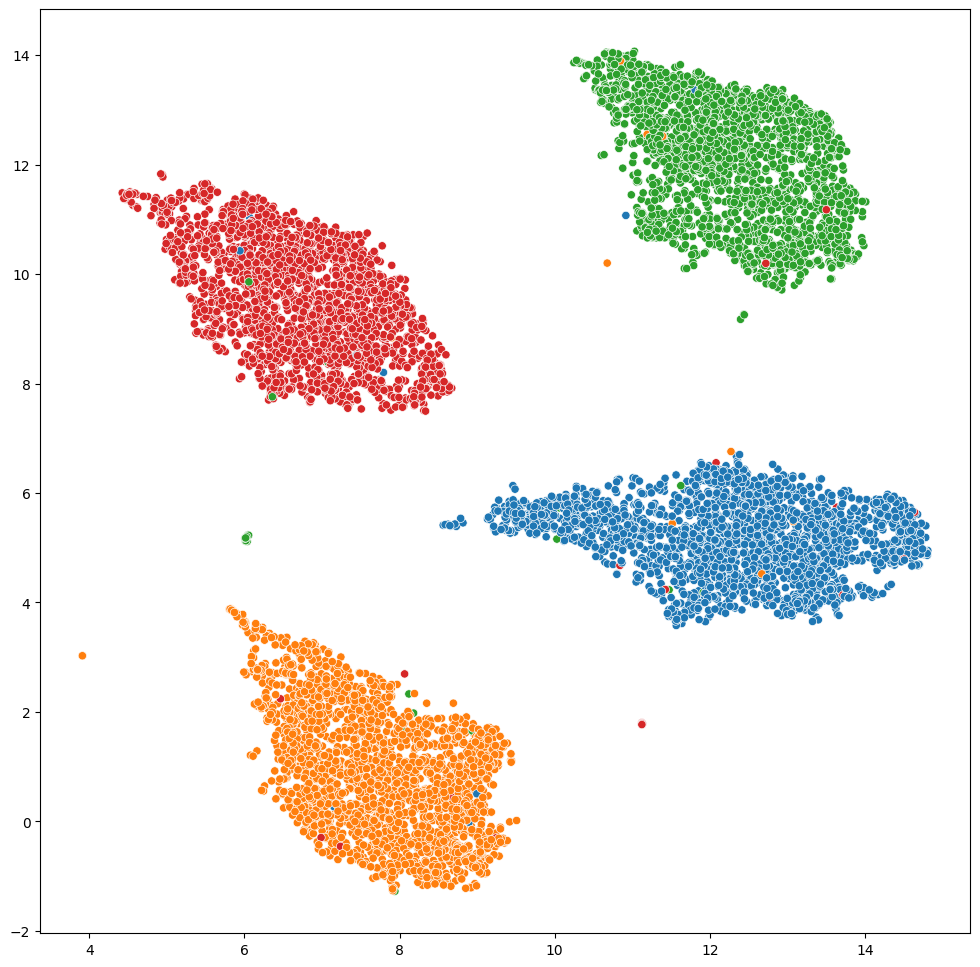

In [10]:
reducer = umap.UMAP()
embedding2 = reducer.fit_transform(embeddings, labels)
plt.figure(figsize=(12,12))
sns.scatterplot(
    x=embedding2[:, 0],
    y=embedding2[:, 1],
    c=[sns.color_palette()[x] for x in labels])
plt.show()